# Chapter 5. Support Vector Machine (SVM, 支援向量機)

Project Goal: SVM, 一種可以執行分類與回歸任務的演算法

# Linear SVM Classification

在不同類別之間放入決策邊界時, 要盡可能遠離最近的實例, 才可以減少被新的訓練資料或離群值影響的情況, 此稱為大邊距分類(large margin classification)

注意：SVM對特徵的scale很敏感, 所以也需要用StandardScaler

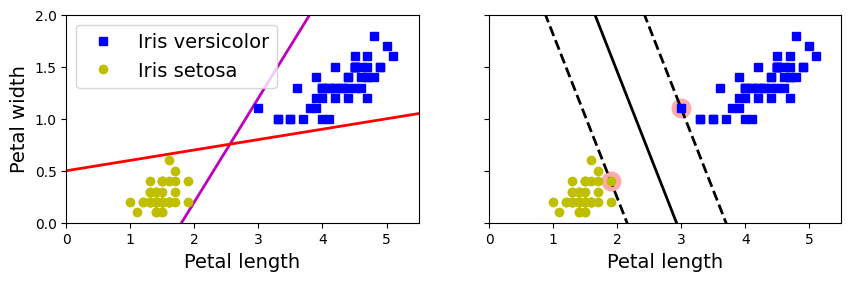

In [4]:
from sklearn.svm import SVC
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]                        # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model (右圖)
svm_clf = SVC(kernel="linear", C=float("1e9"))
svm_clf.fit(X, y)

# Bad models (左圖)
x0 = np.linspace(0, 5.5, 200)
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

# 在同一筆資料的分類方式中, 左圖與右圖相比之下, 右圖的分類狀況會更好
# 因為右圖的決策邊界距離兩種分類更遠（有更寬的margin）, 代表較不容易因為離群值而分類錯誤, 也可以更好的處理新來的資料
# 故 稱為 大邊距分類 (large margin classification)

# 右圖的虛線代表分類的最邊緣值(edge), 也就是說, 我們要想辦法讓兩條虛線的距離最大化
# 而在兩條虛線之上的實例(圈起來者)會決定決策邊界, 所以他們稱為支援向量 (support vector)

# Soft Margin Classification

Hard Margin Classification 會嚴格要求將所有資料分開, 但就代表: (1) 只能處理可線性分隔的資料, (2) 對離群值很敏感

故 使用 Soft Margin Classification 會更靈活, 也就是限制 margin violation (不在虛線左/右的實例) 的情況

In [5]:
# 基本用法

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]                         # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)        # Iris Viginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()), 
    ("linear_svc", LinearSVC(C = 1, loss="hinge")),
])

svm_clf.fit(X, y)
print("Prediction: ", svm_clf.predict([[5.5, 1.7]]))

Prediction:  [1.]


/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C是什麼？應該設定多少？

In [ ]:
# C 愈大, 代表分類愈強制; 反之代表 margin violation 愈可以被接受
# 比較看看 C=1, C=100 的差別
scaler = StandardScaler()
svm_clf1 = LinearSVC(C = 1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C = 100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
    ("scaler", StandardScaler()), 
    ("linear_svc", svm_clf1),
])
scaled_svm_clf1.fit(X, y)

scaled_svm_clf2 = Pipeline([
    ("scaler", StandardScaler()), 
    ("linear_svc", svm_clf2),
])
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
# 這段 code 不work, 因為 mean_ 跟 scale_ 已經不支援了...
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])
plt.show()

# 這段程式輸出的結果是 p.151 中間的圖
# 可以看出, C愈大, 街道會愈窄(分類更強制, violation愈少), 但也更容易 overfit

# Nonlinear SVM Classification

用先前提到的 PolynomialFeatures, 先將資料加入第二個特徵轉換成可以用線性分類的新資料, 再進行操作

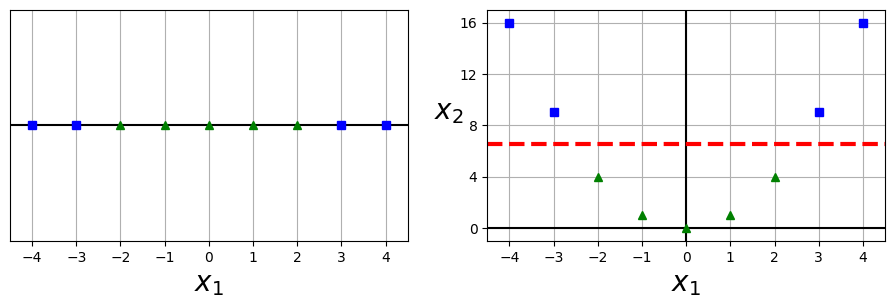

In [15]:
# 下圖中, 左邊為原先的資料 (只有一個特徵, 且無法以線性分割)
# 右圖為多項式轉換後的新資料 (加入第二個新的特徵 x2 = x1^2, 就可以線性分割了)

# reshape() 裡面出現 -1, 代表該項目會自動計算
# 也就是8個資料, reshape(-1, 2) = reshape(4, 2)
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)
plt.show()


# 範例: make_moons()

/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


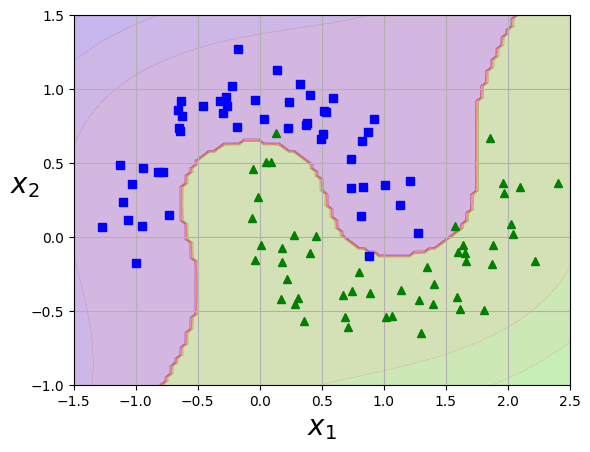

In [17]:
# make_moons() 會產生一個資料組, 其分布看起來像是兩個交纏的半圓
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
polynomial_svm_clf = Pipeline([
    ("ploy_features", PolynomialFeatures(degree=3)), 
    ("scaler", StandardScaler()), 
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])
polynomial_svm_clf.fit(X, y)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()


# Polynomial Kernel

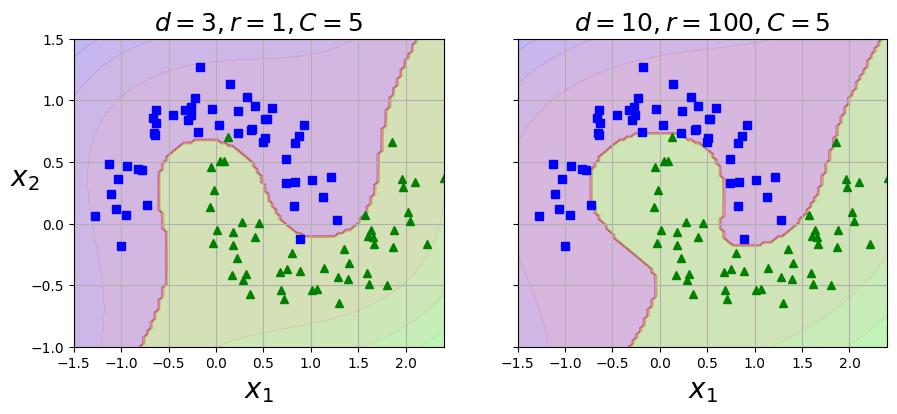

In [19]:
# 比較兩種超參數的情況

from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()), 
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()), 
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

# coef0 控制的是模型受高次多項式及低次多項式影響的程度

# RBF Kernel (Radial Basis Function Kernel)

除了加入更多特徵之外, 另外一種處理非線性問題的方式是使用相似度函數 (similarity function), 用以衡量各個實例與特定界標 (landmark) 的相似程度

例如：以 高斯徑向基底函數(Gaussian RBF) 作為相似度函數, 詳細可見 p.155~p.156

In [ ]:
# 基本用法
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()), 
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

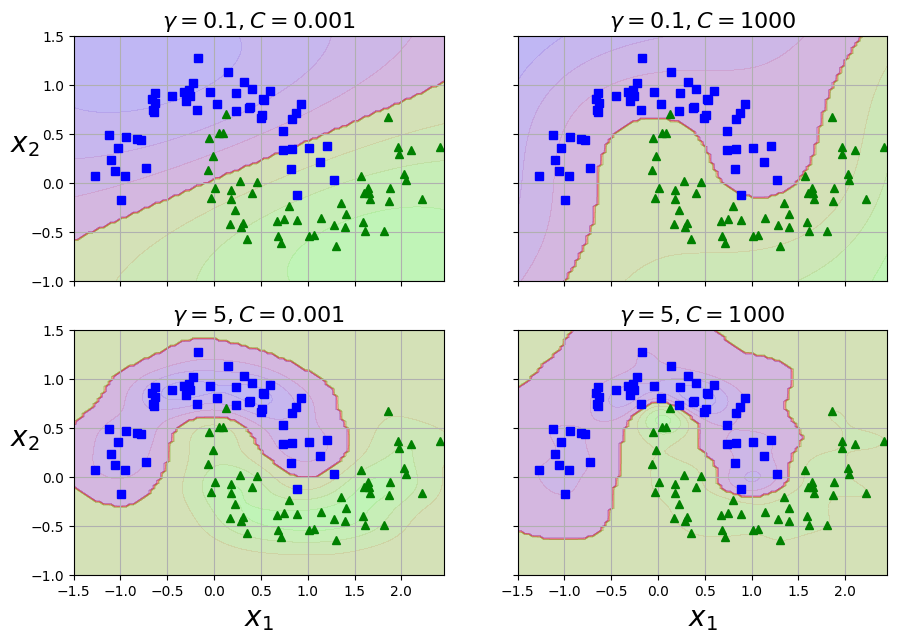

In [22]:
# 比較不同超參數的結果
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()), 
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
    ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

# 從下圖可以看出
# gamma 愈大, 鐘型曲線愈窄(分類更嚴格), 也就是決策邊界愈不規則
# 所以 gamma 很像是 regularization參數（正則化參數）, overfitting時要降低它, 而underfitting時增加

# SVM Regression (SVM回歸)

SVM回歸的目的, 是盡量將實例放在街道上面(決策邊界之間), 同時控制邊距違規(邊界之外的實例)

In [24]:
# 基本用法 

from sklearn.svm import LinearSVR

np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

# epsilon (ϵ) 即是 街道的寬度
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR(epsilon=1.5, random_state=42)

/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


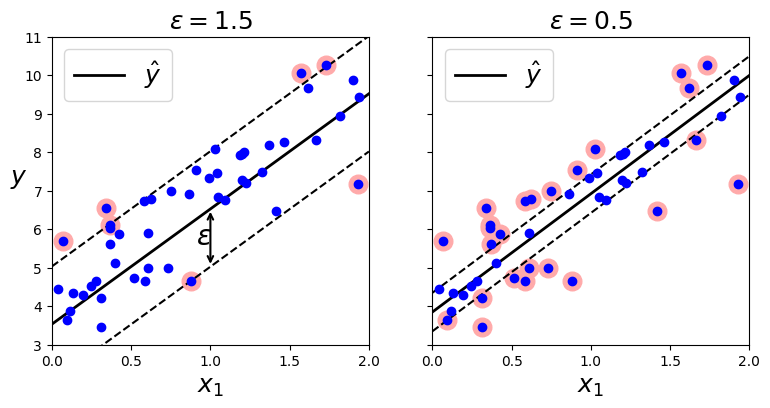

In [29]:
# 兩種不同的 epsilon (ϵ), 決定兩種街道寬度
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

def plot_svm_regression(svm_reg, X, y, axes):
    xls = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(xls)
    plt.plot(xls, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(xls, y_pred + svm_reg.epsilon, "k--")
    plt.plot(xls, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

# 有紅色圈 與 沒有紅色圈 代表兩種不同的預測

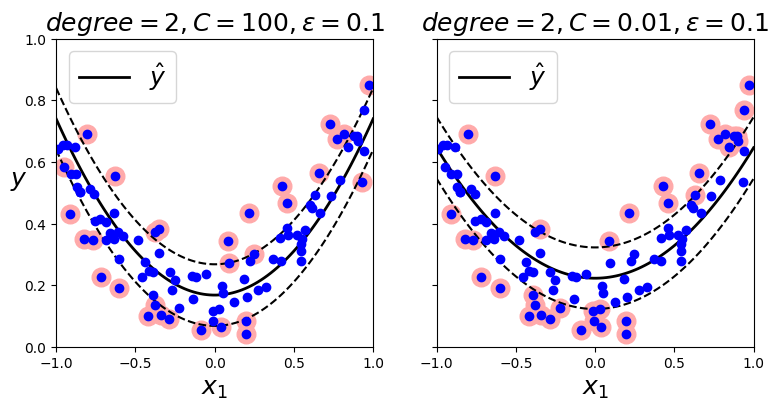

In [30]:
# 使用 二次多項式kernel 來進行 SVM回歸
from sklearn.svm import SVR

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

# 由下圖可見, C 愈小 (正則化程度愈大), 街道就愈寬

# Theorem

蠻複雜難懂的, 詳細請見 p.160~ p.168